## Weather Forecasting using ML and GA (Past Data)

### Data Extraction

In [1]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd

city = Point(40.7128, -74.0060) 
start_date = datetime(2021, 11, 1)  
end_date = datetime(2024, 1, 31) 

data = Daily(city, start=start_date, end=end_date)
data = data.fetch()

data = pd.DataFrame(data)
print(data)

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-11-01  14.6  12.2  17.8   0.0   0.0  262.0  11.6   NaN  1016.9   NaN
2021-11-02  11.6   8.9  12.8   0.3   0.0  269.0  12.7   NaN  1022.6   NaN
2021-11-03   9.8   7.2  13.9   0.0   0.0  274.0   8.4   NaN  1024.4   NaN
2021-11-04   9.7   7.8  12.8   0.0   0.0   63.0   9.7   NaN  1027.0   NaN
2021-11-05  10.1   6.1  13.9   0.0   0.0   31.0   8.9   NaN  1027.5   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-01-27   6.7   5.6   7.8   0.0   0.0  317.0   5.6   NaN  1022.4   NaN
2024-01-28   4.1   3.3   6.0  19.4   0.0   42.0  17.2   NaN  1010.2   NaN
2024-01-29   3.4   2.8   4.4   1.1   0.0   20.0   7.7   NaN  1011.2   NaN
2024-01-30   2.5   2.2   3.3   0.0   0.0   67.0   7.9   NaN  1022.6   NaN
2024-01-31   2.9   1.7   4.0   0.1   0.0   65.0   8.6   NaN  1020.5   NaN

[822 rows x 10 columns]


### Data Preprocessing and Visualization

In [2]:
data=data.drop(columns=['wpgt','tsun'])
data=data.dropna()

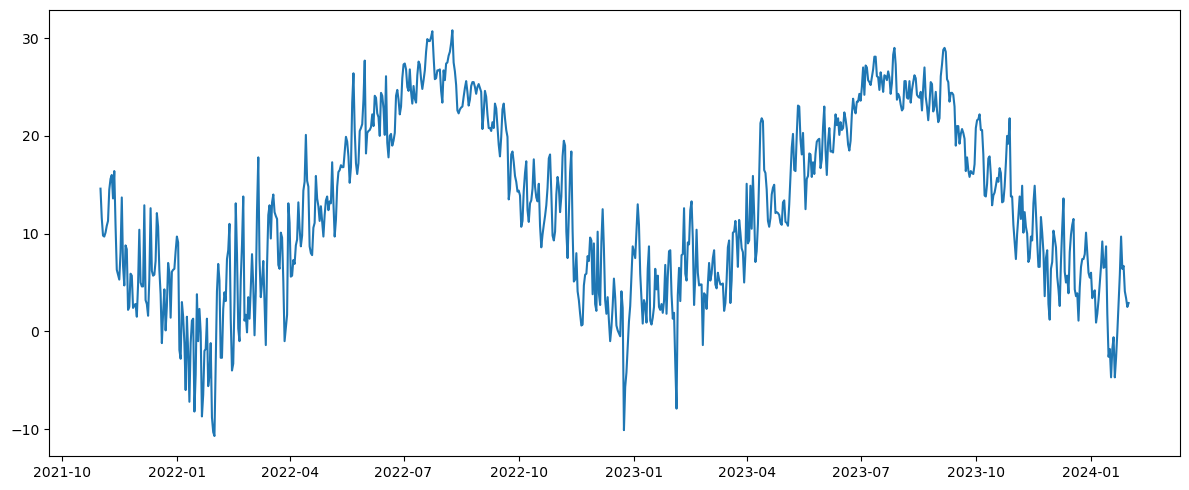

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(data['tavg'])
plt.tight_layout()
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
X=data.drop(columns='tavg')
Y=data['tavg']
X=StandardScaler().fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### ML without GA

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred_baseline = model.predict(X_test)

baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)
print(f"Baseline MSE: {baseline_mse}, R²: {baseline_r2}")


Baseline MSE: 0.5265557272727284, R²: 0.9936905277092452


### ML with GA

In [10]:
from sklearn.model_selection import cross_val_score

def objective_function(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()

 The best solution found:                                                                           
 [52.  8.  3.]

 Objective function:
 0.49028796317503803


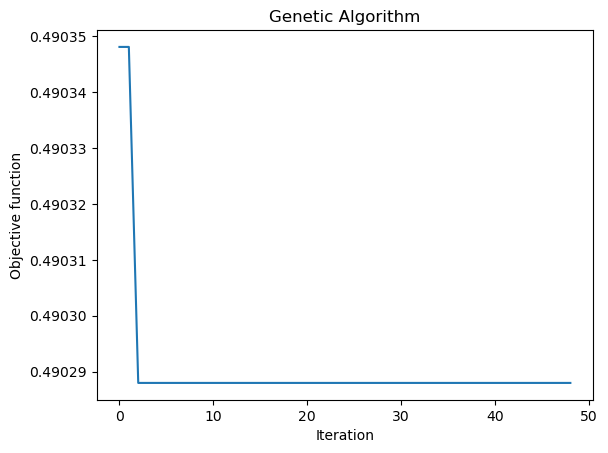

Optimized MSE: 0.5210702939087019, R²: 0.9937562571050536


In [11]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
param_bounds = np.array([
    [50,60],  # n_estimators
    [5,8],    # max_depth
    [2,5]     # min_samples_split
])

# Run GA
ga_model = ga(function=objective_function, dimension=3, variable_type='int', variable_boundaries=param_bounds)
ga_model.run()

best_params = ga_model.output_dict['variable']
optimized_model = RandomForestRegressor(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    min_samples_split=int(best_params[2]),
    random_state=42
)
optimized_model.fit(X_train, y_train)
y_pred_optimized = optimized_model.predict(X_test)

optimized_mse = mean_squared_error(y_test, y_pred_optimized)
optimized_r2 = r2_score(y_test, y_pred_optimized)
print(f"Optimized MSE: {optimized_mse}, R²: {optimized_r2}")


### Comparison

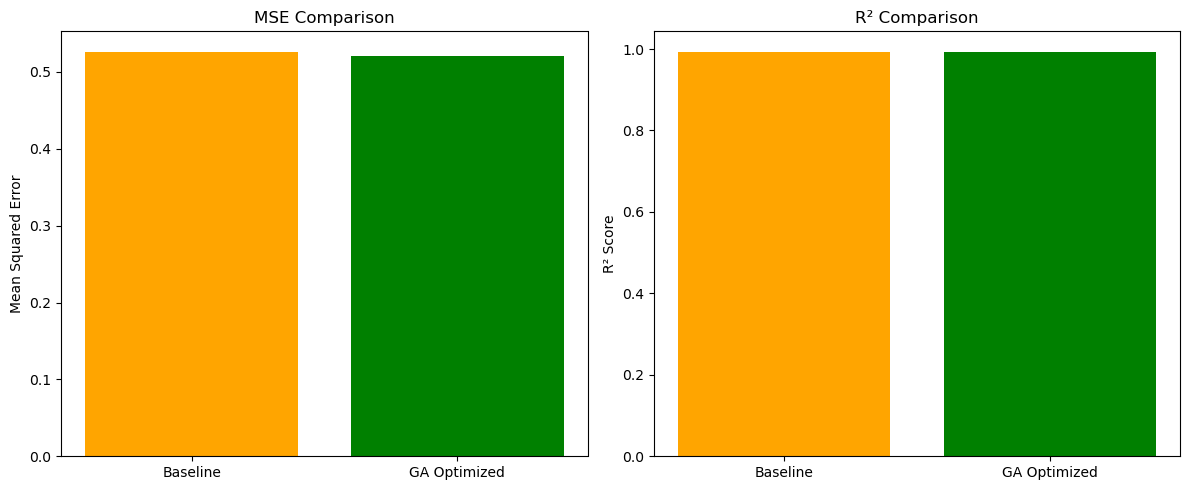

In [12]:

labels = ['Baseline', 'GA Optimized']
mse_values = [baseline_mse, optimized_mse]
r2_values = [baseline_r2, optimized_r2]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, mse_values, color=['orange', 'green'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 2, 2)
plt.bar(labels, r2_values, color=['orange', 'green'])
plt.title('R² Comparison')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


From the above comparison we can see that there isn't much difference between with and without GA for this data because randomforest is an ensemble technique, therefore it captures and gets the best tree. Hence, there isn't much difference.

## END